<a href="https://colab.research.google.com/github/Muntasir2179/bangla-accent-classification/blob/model-testing/Accent_Classification_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [1]:
!pip install resampy

In [2]:
# data visualization libraries
import resampy
import librosa
import pandas as pd
import os
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# data preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# model building libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D)

In [3]:
audio_dataset_path='/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/'
metadata=pd.read_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio_trace_metadata.csv')

In [4]:
metadata = metadata.sample(frac=1, random_state=42)
metadata.head()

,file_name,folder_name,accent
694,shatkhira_audio_04.wav,shatkhira,shatkhira
665,rajshahi_audio_18.wav,rajshahi,rajshahi
63,barishal_audio_63.wav,barishal,barishal
533,pabna_audio_28.wav,pabna,pabna
66,barishal_audio_66.wav,barishal,barishal


In [5]:
len(metadata)

798

# Extracting features

In [15]:
# defining a function that can extract features from audio files
import librosa

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [16]:
# collecting features for all the audio files

from tqdm import tqdm

extracted_features=[]

for index_num, row in tqdm(metadata.iterrows()):
  accent_label = row['accent']
  file_path = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/' + str(row['folder_name']) + '/' + str(row['file_name'])
  data = features_extractor(file_path)
  extracted_features.append([data, accent_label])

798it [01:37,  8.19it/s]


In [17]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-303.31775, 143.74261, -9.693616, 28.3284, -5...",shatkhira
1,"[-294.3459, 139.74811, -43.741085, 17.729439, ...",rajshahi
2,"[-328.56235, 134.61555, -32.152763, 26.235819,...",barishal
3,"[-295.63644, 130.29414, -7.602222, 39.19464, 0...",pabna
4,"[-331.84305, 133.63618, -28.187292, 21.035797,...",barishal


In [10]:
# saving the extracted features dataframe into drive for later use
extracted_features_df.to_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/128_audio_features.csv')

In [18]:
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [19]:
X.shape, y.shape

((798, 128), (798,))

# Applying onehot encoding on labels

In [20]:
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# Spliting dataset into train and test

In [21]:
# split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the details
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])

Number of training samples =  638
Number of testing samples =  160


# Helper functions for plotting and evaluation

In [22]:
# function for Ploting history (also known as a loss curve or a training curve)
def plot_history(history):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [36]:
# function to predict and generate decoded value of labels
def model_prediction(x_test, y_true, model, number_of_labels, onehot_encoder):
  y_pred = model.predict(x_test, verbose=0)
  predictions = []
  for row in y_pred:
    label = np.zeros(number_of_labels)
    label[np.argmax(row)] = 1
    label.reshape(1, -1)
    predictions.append(label.tolist())
    label = None
  y_test_decoded = onehot_encoder.inverse_transform(y_true)
  y_pred_decoded = onehot_encoder.inverse_transform(predictions)
  return y_pred_decoded, y_test_decoded

In [41]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_evaluation_parameters(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions))
  print('Precision score: ', precision_score(y_test_for_eval, predictions, average='weighted'))
  print('Recall score   : ', recall_score(y_test_for_eval, predictions, average='weighted'))
  print('F1 Score       : ', f1_score(y_test_for_eval, predictions, average='weighted'))
  print('\n--------------------------------------------\n')
  print(classification_report(y_test_for_eval, predictions))

In [43]:
def show_confusion_matrix(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  cm = confusion_matrix(y_test_for_eval, predictions, labels=metadata['accent'].unique())
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
  fig, ax = plt.subplots(figsize=(20,13))
  disp.plot(ax=ax)
  plt.show()

# Building ANN model

In [23]:
# Construct model
num_labels = y.shape[1]
ANN_Model = Sequential()
ANN_Model.add(Dense(1000, activation="relu", input_shape=(128,)))
ANN_Model.add(Dense(750, activation="relu"))
ANN_Model.add(Dense(500, activation="relu"))
ANN_Model.add(Dense(250, activation="relu"))
ANN_Model.add(Dense(100, activation="relu"))
ANN_Model.add(Dense(50, activation="relu"))
ANN_Model.add(Dense(num_labels, activation="softmax"))

In [24]:
ANN_Model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

In [25]:
num_epochs = 50
num_batch_size = 5

ANN_Results = ANN_Model.fit(X_train,
                            y_train,
                            batch_size=num_batch_size,
                            epochs=num_epochs,
                            validation_data=(X_test, y_test))

Epoch 1/50
128/128 [==============================] - 6s 8ms/step - loss: 3.1090 - accuracy: 0.1693 - val_loss: 2.2842 - val_accuracy: 0.1562
Epoch 2/50
128/128 [==============================] - 1s 5ms/step - loss: 1.8784 - accuracy: 0.3699 - val_loss: 1.8473 - val_accuracy: 0.3187
Epoch 3/50
128/128 [==============================] - 1s 5ms/step - loss: 1.4697 - accuracy: 0.4859 - val_loss: 1.4138 - val_accuracy: 0.5000
Epoch 4/50
128/128 [==============================] - 1s 6ms/step - loss: 1.3255 - accuracy: 0.5486 - val_loss: 1.5702 - val_accuracy: 0.5375
Epoch 5/50
128/128 [==============================] - 1s 5ms/step - loss: 1.0041 - accuracy: 0.6552 - val_loss: 1.1632 - val_accuracy: 0.6125
Epoch 6/50
128/128 [==============================] - 1s 5ms/step - loss: 0.7901 - accuracy: 0.7257 - val_loss: 0.9725 - val_accuracy: 0.6687
Epoch 7/50
128/128 [==============================] - 1s 5ms/step - loss: 0.6836 - accuracy: 0.7618 - val_loss: 0.6624 - val_accuracy: 0.7875
Epoch 

In [26]:
test_accuracy=ANN_Model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.90625


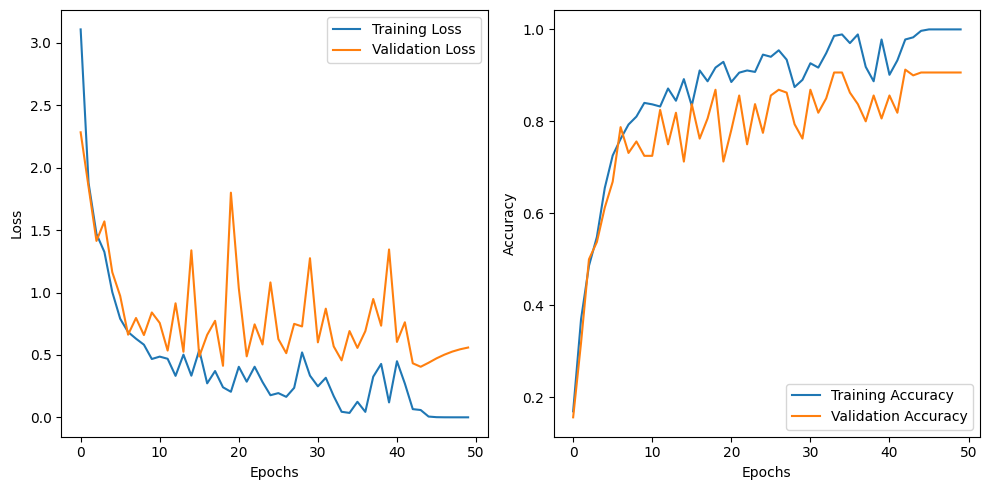

In [27]:
plot_history(ANN_Results)

In [42]:
show_evaluation_parameters(X_test, y_test, ANN_Model, 12, encoder)

Accuracy score :  0.90625
Precision score:  0.9049964577637274
Recall score   :  0.90625
F1 Score       :  0.8969186846480891

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.89      1.00      0.94        17
      bogura       0.95      1.00      0.98        21
  chottogram       0.82      0.96      0.88        24
    kurigram       0.94      1.00      0.97        15
 maymenshing       1.00      1.00      1.00         5
    noakhali       0.89      0.89      0.89        18
       pabna       1.00      1.00      1.00         8
 puran dhaka       0.93      1.00      0.97        14
    rajshahi       0.80      0.36      0.50        11
   shatkhira       0.90      1.00      0.95         9
      sylhet       0.80      0.67      0.73         6
  thakurgaon       1.00      0.75      0.86        12

    accuracy                           0.91       160
   macro avg       0.91      0.89      0.89       160
weighted avg   

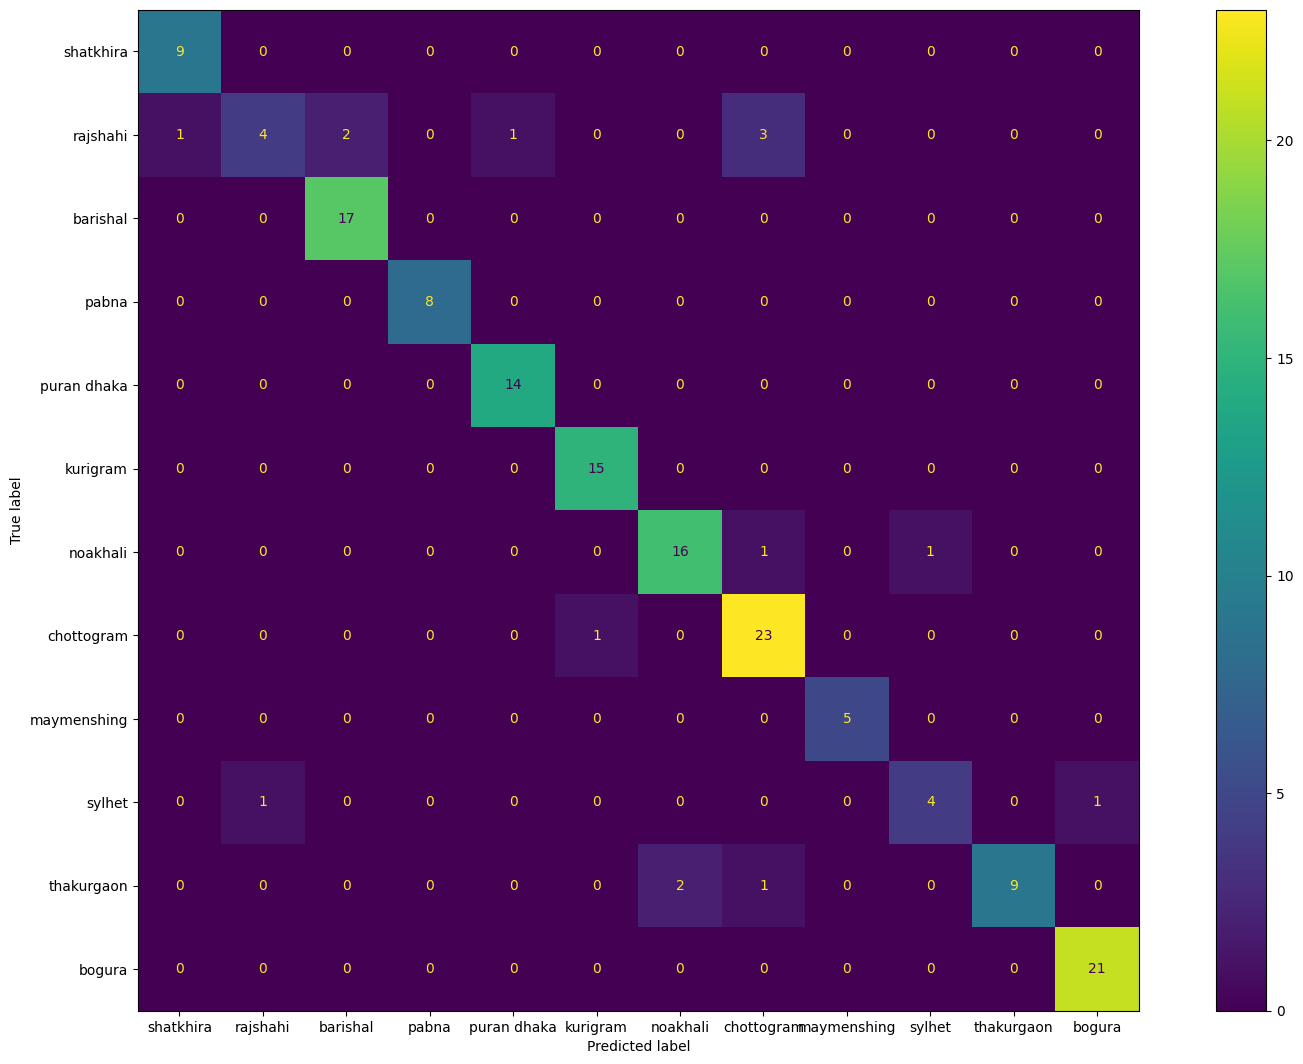

In [44]:
show_confusion_matrix(X_test, y_test, ANN_Model, 12, encoder)

# Building CNN1D model

In [45]:
CNN1D_Model = Sequential()
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu", input_shape=(X_train.shape[1], 1),))
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=num_labels, activation="softmax"))

In [46]:
CNN1D_Model.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [47]:
CNN1D_Results = CNN1D_Model.fit(X_train,
                                y_train,
                                batch_size=5,
                                epochs=250,
                                validation_data=(X_test, y_test))

Epoch 1/250
128/128 [==============================] - 7s 12ms/step - loss: 2.7366 - accuracy: 0.1317 - val_loss: 2.3828 - val_accuracy: 0.1312
Epoch 2/250
128/128 [==============================] - 1s 7ms/step - loss: 2.3542 - accuracy: 0.1379 - val_loss: 2.2543 - val_accuracy: 0.1250
Epoch 3/250
128/128 [==============================] - 1s 8ms/step - loss: 2.3562 - accuracy: 0.1818 - val_loss: 2.2875 - val_accuracy: 0.2125
Epoch 4/250
128/128 [==============================] - 1s 7ms/step - loss: 2.3052 - accuracy: 0.2069 - val_loss: 2.2929 - val_accuracy: 0.1813
Epoch 5/250
128/128 [==============================] - 1s 7ms/step - loss: 2.2482 - accuracy: 0.1850 - val_loss: 2.1446 - val_accuracy: 0.2250
Epoch 6/250
128/128 [==============================] - 1s 7ms/step - loss: 2.1577 - accuracy: 0.2335 - val_loss: 2.1688 - val_accuracy: 0.2188
Epoch 7/250
128/128 [==============================] - 1s 8ms/step - loss: 2.2431 - accuracy: 0.1881 - val_loss: 2.3042 - val_accuracy: 0.181

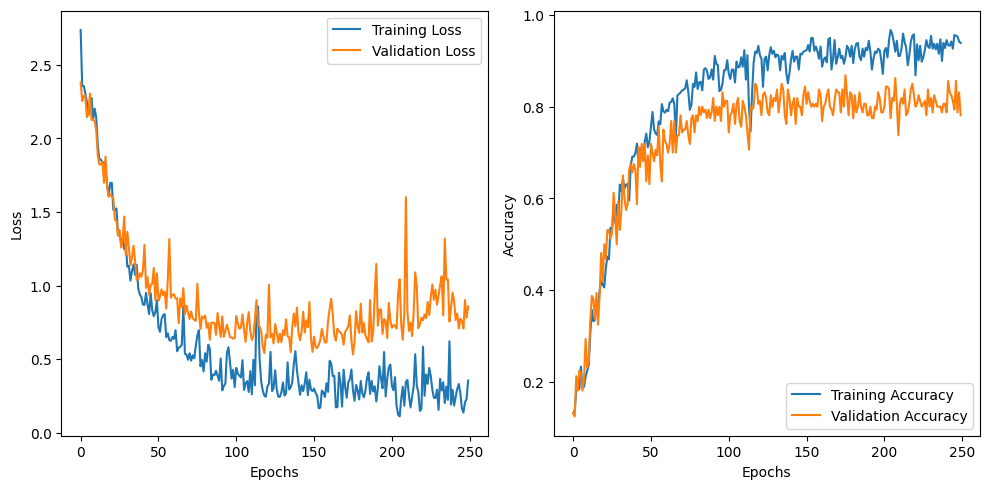

In [48]:
plot_history(CNN1D_Results)

In [49]:
show_evaluation_parameters(X_test, y_test, CNN1D_Model, 12, encoder)

Accuracy score :  0.78125
Precision score:  0.7781289251207729
Recall score   :  0.78125
F1 Score       :  0.7642597288189643

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.85      1.00      0.92        17
      bogura       0.84      1.00      0.91        21
  chottogram       0.75      0.62      0.68        24
    kurigram       1.00      0.93      0.97        15
 maymenshing       1.00      1.00      1.00         5
    noakhali       0.75      0.67      0.71        18
       pabna       0.78      0.88      0.82         8
 puran dhaka       0.61      1.00      0.76        14
    rajshahi       0.33      0.18      0.24        11
   shatkhira       0.90      1.00      0.95         9
      sylhet       1.00      0.33      0.50         6
  thakurgaon       0.70      0.58      0.64        12

    accuracy                           0.78       160
   macro avg       0.79      0.77      0.76       160
weighted avg   

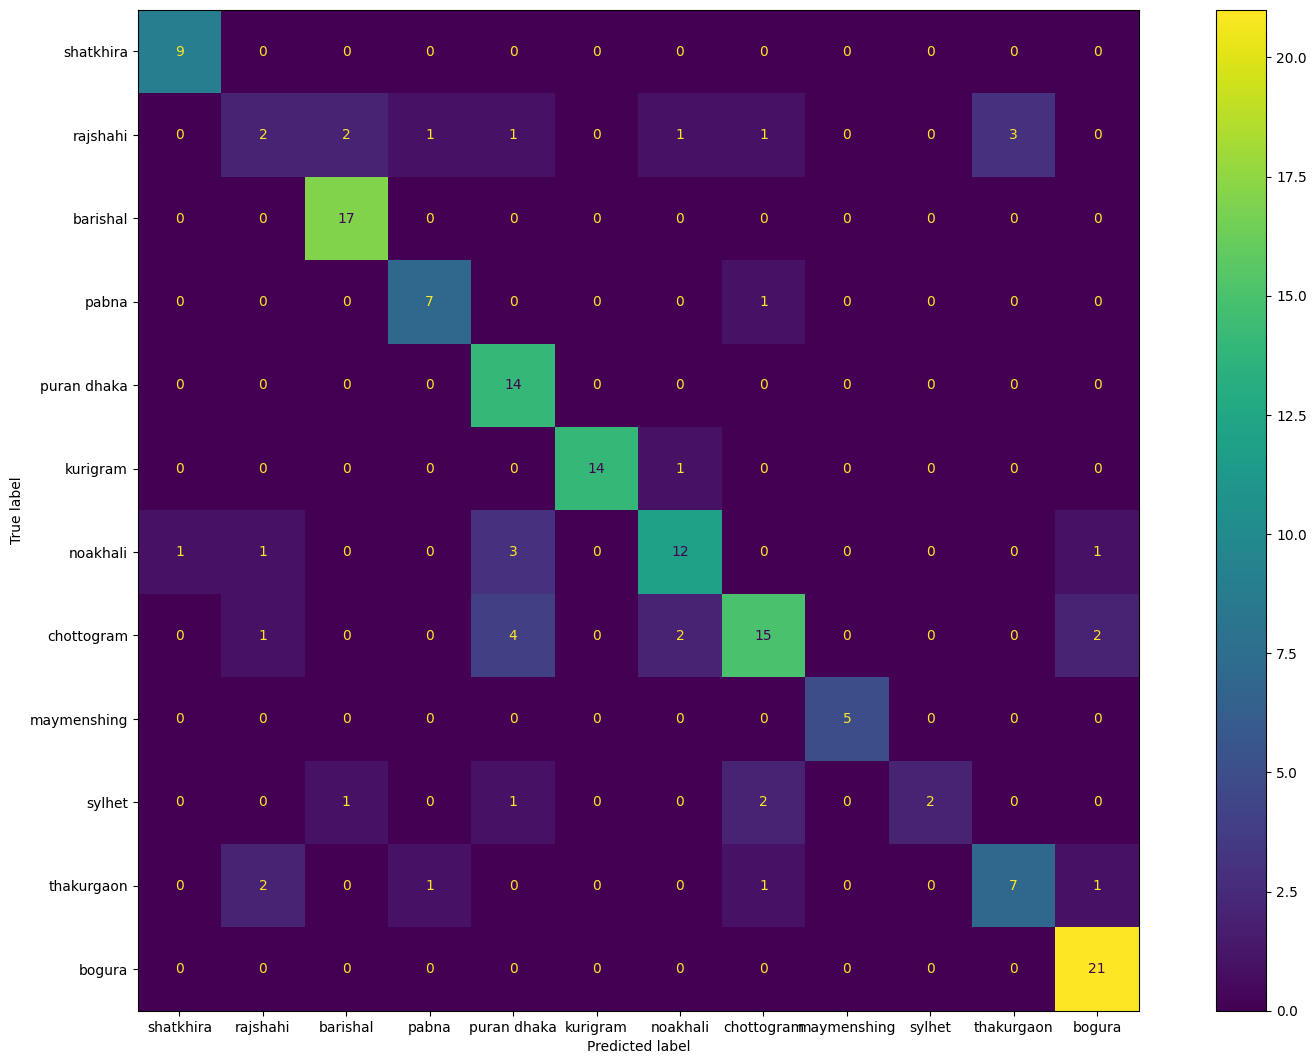

In [50]:
show_confusion_matrix(X_test, y_test, CNN1D_Model, 12, encoder)

# Building CNN2D model

In [51]:
# reshaping features to pass into the model
X_train_reshaped = X_train.reshape(X_train.shape[0], 16, 8, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 16, 8, 1)

In [61]:
CNN2D_Model = Sequential()
CNN2D_Model.add(Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1)))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Dropout(0.1))
CNN2D_Model.add(Flatten())
CNN2D_Model.add(Dense(256, activation="tanh"))
CNN2D_Model.add(Dense(num_labels, activation="softmax"))

In [62]:
CNN2D_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [63]:
CNN2D_Results = CNN2D_Model.fit(X_train_reshaped,
                                y_train,
                                batch_size=5,
                                epochs=13,
                                validation_data=(X_test_reshaped, y_test))

Epoch 1/13
128/128 [==============================] - 2s 6ms/step - loss: 1.8413 - accuracy: 0.4075 - val_loss: 1.3431 - val_accuracy: 0.5625
Epoch 2/13
128/128 [==============================] - 1s 5ms/step - loss: 1.1219 - accuracy: 0.6395 - val_loss: 1.0583 - val_accuracy: 0.6687
Epoch 3/13
128/128 [==============================] - 1s 5ms/step - loss: 0.6716 - accuracy: 0.7962 - val_loss: 0.7625 - val_accuracy: 0.7500
Epoch 4/13
128/128 [==============================] - 1s 5ms/step - loss: 0.4172 - accuracy: 0.8668 - val_loss: 0.8914 - val_accuracy: 0.7312
Epoch 5/13
128/128 [==============================] - 1s 6ms/step - loss: 0.3587 - accuracy: 0.8793 - val_loss: 0.5616 - val_accuracy: 0.8188
Epoch 6/13
128/128 [==============================] - 1s 6ms/step - loss: 0.1509 - accuracy: 0.9624 - val_loss: 0.5524 - val_accuracy: 0.8562
Epoch 7/13
128/128 [==============================] - 1s 7ms/step - loss: 0.1419 - accuracy: 0.9561 - val_loss: 0.7914 - val_accuracy: 0.7937
Epoch 

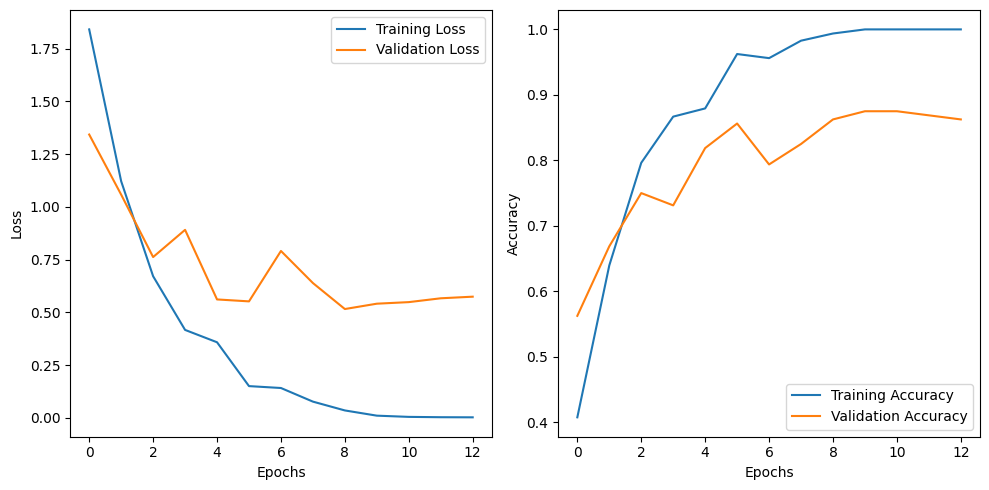

In [64]:
plot_history(CNN2D_Results)

In [67]:
show_evaluation_parameters(X_test_reshaped, y_test, CNN2D_Model, 12, encoder)

Accuracy score :  0.8625
Precision score:  0.8613497063021519
Recall score   :  0.8625
F1 Score       :  0.8572470393767574

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.77      1.00      0.87        17
      bogura       0.91      1.00      0.95        21
  chottogram       0.87      0.83      0.85        24
    kurigram       1.00      1.00      1.00        15
 maymenshing       1.00      1.00      1.00         5
    noakhali       0.88      0.78      0.82        18
       pabna       1.00      0.88      0.93         8
 puran dhaka       0.81      0.93      0.87        14
    rajshahi       0.56      0.45      0.50        11
   shatkhira       0.90      1.00      0.95         9
      sylhet       0.75      0.50      0.60         6
  thakurgaon       0.90      0.75      0.82        12

    accuracy                           0.86       160
   macro avg       0.86      0.84      0.85       160
weighted avg     

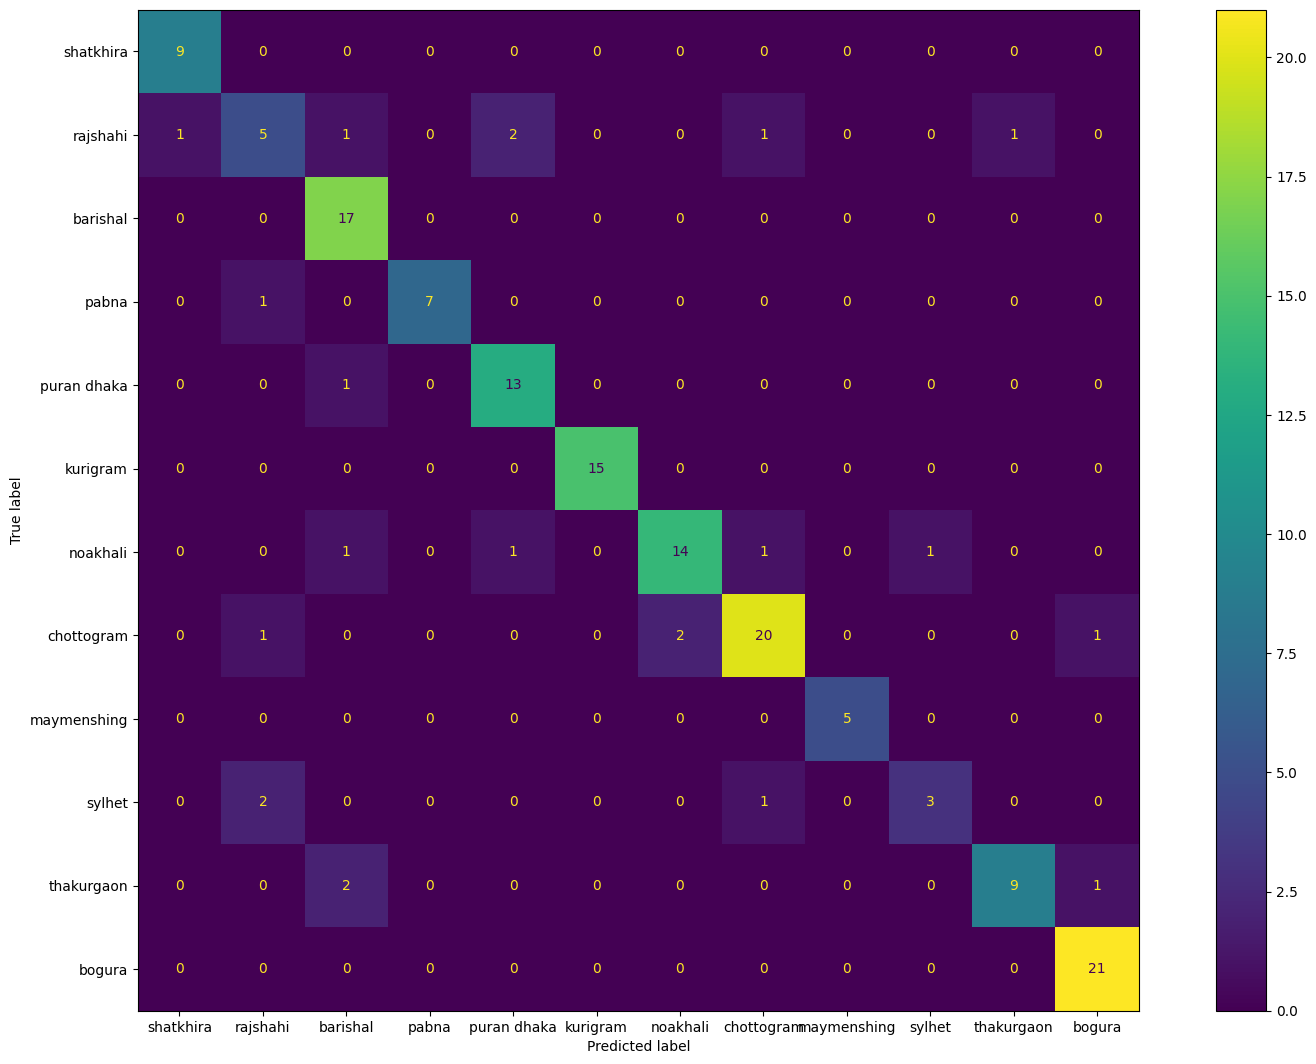

In [68]:
show_confusion_matrix(X_test_reshaped, y_test, CNN2D_Model, 12, encoder)